# S2RA-2023_write_temp_zarr_HMEM_localCluster

**Date:** <br>
May 1st 2023 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/8 <br>
**Author(s):**<br>
Thomas Moore<br>

## We are using NCI ARE

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

# ARE cluster

# or start a local cluster

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
print(client)

<Client: 'tcp://127.0.0.1:39905' processes=7 threads=21, memory=765.00 GiB>


# open all temperature NC files

In [10]:
%%time
ds_temp = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True)

CPU times: user 4.15 s, sys: 1.12 s, total: 5.28 s
Wall time: 9.56 s


# rename time and lat/lon and depth

In [12]:
ds_temp = ds_temp.rename({'time_counter':'time','nav_lon': 'lon', 'nav_lat': 'lat','deptht':'depth'})

In [14]:
ds_temp = ds_temp[['temp','areat']]

In [15]:
ds_temp.nbytes/1e9

226.931662708

In [16]:
ds_temp

<xarray.Dataset>
Dimensions:  (time: 507, depth: 75, y: 1021, x: 1442)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2023-03-01T12:00:00
Dimensions without coordinates: y, x
Data variables:
    temp     (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
    areat    (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

# Deal with inconsistant and crazy "times" across collection of S2 netcdf files

In [17]:
S2_time_df = ds_temp.time.to_dataframe()
truncated_S2_time = pd.to_datetime(S2_time_df.time).dt.date
year_month_day_strings = [ string[:-2]+'15' for string in truncated_S2_time.astype(str) ]
new_S2_datetime = pd.to_datetime(year_month_day_strings)
#replace time with cleaned version
ds_temp['time'] = new_S2_datetime

In [18]:
ds_temp

<xarray.Dataset>
Dimensions:  (time: 507, depth: 75, y: 1021, x: 1442)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x
Data variables:
    temp     (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
    areat    (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

# SAVE ocean tgrid zarr file

### rechunk to make chunks consistent

In [19]:
ds_temp = ds_temp.chunk({"x": 250, "y": 250,"time":507,"depth":1})

In [20]:
ds_temp

<xarray.Dataset>
Dimensions:  (time: 507, depth: 75, y: 1021, x: 1442)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lat      (y, x) float32 dask.array<chunksize=(250, 250), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 250), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x
Data variables:
    temp     (time, depth, y, x) float32 dask.array<chunksize=(507, 1, 250, 250), meta=np.ndarray>
    areat    (time, y, x) float32 dask.array<chunksize=(507, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

## with 700GB mem can run without `rechunker`

In [21]:
%%time
ds_temp.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.temp.zarr',consolidated=True)

CPU times: user 1min 37s, sys: 33.3 s, total: 2min 10s
Wall time: 7min 1s


# load and check

In [24]:
temp = xr.open_zarr('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.temp.zarr',consolidated=True)

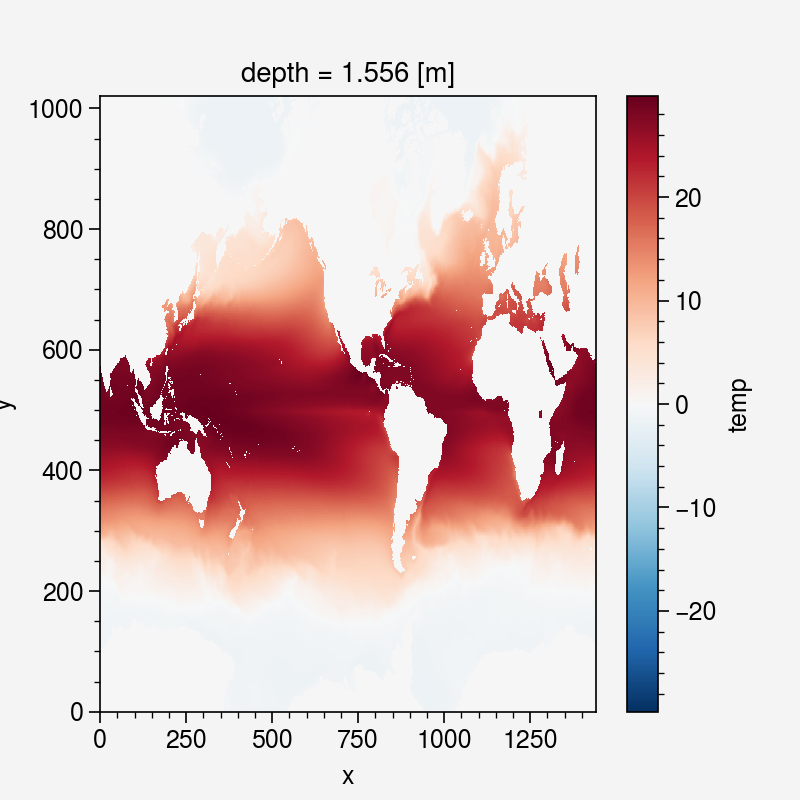

In [28]:
temp.temp.isel(depth=1).mean('time').plot()

# Break glass in case of emergency
# $\Downarrow$

In [22]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 179.43 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32937,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: 17 minutes ago,Total memory: 179.43 GiB
Comm: tcp://127.0.0.1:35361,Total threads: 4
Dashboard: /proxy/39205/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:42287,


In [29]:
client.shutdown()

In [23]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 179.43 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32937,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: 17 minutes ago,Total memory: 179.43 GiB
Comm: tcp://127.0.0.1:40325,Total threads: 4
Dashboard: /proxy/33119/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:42287,
